In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

%matplotlib inline

In [2]:
class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        self.fbi_size = 7
                
        super().__init__()
                        
        self.out_in  = nn.RNN(self.input_size, self.output_size, nonlinearity='relu')
        self.fbi_out = nn.RNN(self.output_size, self.fbi_size, nonlinearity='relu')           
        self.out_fbi = nn.Linear(self.fbi_size, self.output_size)
        
        # Set recurrent weights to identity matrix
        self.out_in.weight_hh_l0.data *= 0
        self.fbi_out.weight_hh_l0.data *= 0
#         self.out_in.weight_hh_l0.data = torch.zeros(self.output_size,self.output_size)
#         self.fbi_out.weight_hh_l0.data = torch.zeros(self.fbi_size,self.fbi_size))
        self.out_in.weight_hh_l0.requires_grad = False
        self.fbi_out.weight_hh_l0.requires_grad = False
    
        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, input_pattern, output_activity, fbi_activity):
        
        output_activity,_ = self.out_in(input_pattern,output_activity)
        output_activity += self.out_fbi(fbi_activity)
        
        fbi_activity,_ = self.fbi_out(output_activity,fbi_activity)
                
        return output_activity, fbi_activity
    
    def train(self,epochs,time,all_patterns):
        losses = []
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            input_pattern = all_patterns[pattern_index]
            target = torch.eye(128)[pattern_index]
            
            output_activity = torch.zeros(1,1,self.output_size)
            fbi_activity = torch.zeros(1,1,self.fbi_size)
            input_pattern = input_pattern.expand(1,1,input_pattern.shape[0])
            
            for t in range(time):
                output_activity, fbi_activity = self.forward(input_pattern,output_activity, fbi_activity)
                
            loss = self.lossCriterion(output_activity,target)           
                
            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
            
        return losses

In [3]:
# Create network
dentate_net = dentate_network(lr=0.1)
time = 5
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

In [4]:
dentate_net

dentate_network(
  (out_in): RNN(7, 128)
  (fbi_out): RNN(128, 7)
  (out_fbi): Linear(in_features=7, out_features=128, bias=True)
  (lossCriterion): MSELoss()
)

In [5]:
# Save initial state
w_init = {'out_in': dentate_net.out_in.weight_ih_l0.detach().numpy().flatten(),
          'fbi_out': dentate_net.fbi_out.weight_ih_l0.detach().numpy().flatten(),
          'out_fbi': dentate_net.out_fbi.weight.detach().numpy().flatten()}

b_init = {'out_in': dentate_net.out_in.bias_ih_l0.detach().numpy().flatten(),
          'fbi_out': dentate_net.fbi_out.bias_ih_l0.detach().numpy().flatten(),
          'out_fbi': dentate_net.out_fbi.bias.detach().numpy().flatten()}

output_init = []
mean_output_init = torch.zeros(time)
for pattern in all_patterns:
    output_activity = torch.zeros(1,1,dentate_net.output_size)
    fbi_activity = torch.zeros(1,1,dentate_net.fbi_size)
    pattern = pattern.expand(1,1,pattern.shape[0])
    for t in range(time):
        output_activity,fbi_activity = dentate_net.forward(pattern,output_activity,fbi_activity)
        mean_output_init[t] += torch.mean(output_activity).detach()
    output_init.append(list(output_activity[0,0].detach()))
output_init = np.array(output_init)

In [6]:
# Train network
epochs = 10**5
losses = dentate_net.train(epochs, time, all_patterns)

100%|██████████| 100000/100000 [02:21<00:00, 708.26it/s]


In [7]:
# Save initial state
w_final = {'out_in': dentate_net.out_in.weight_ih_l0.detach().numpy().flatten(),
          'fbi_out': dentate_net.fbi_out.weight_ih_l0.detach().numpy().flatten(),
          'out_fbi': dentate_net.out_fbi.weight.detach().numpy().flatten()}

b_final = {'out_in': dentate_net.out_in.bias_ih_l0.detach().numpy().flatten(),
          'fbi_out': dentate_net.fbi_out.bias_ih_l0.detach().numpy().flatten(),
          'out_fbi': dentate_net.out_fbi.bias.detach().numpy().flatten()}

output_final = []
mean_output_final = torch.zeros(time)
for pattern in all_patterns:
    output_activity = torch.zeros(1,1,dentate_net.output_size)
    fbi_activity = torch.zeros(1,1,dentate_net.fbi_size)
    pattern = pattern.expand(1,1,7)
    for t in range(time):
        output_activity,fbi_activity = dentate_net.forward(pattern,output_activity,fbi_activity)
        mean_output_final[t] += torch.mean(output_activity).detach()
    output_final.append(list(output_activity[0,0].detach()))
output_final = np.array(output_final)

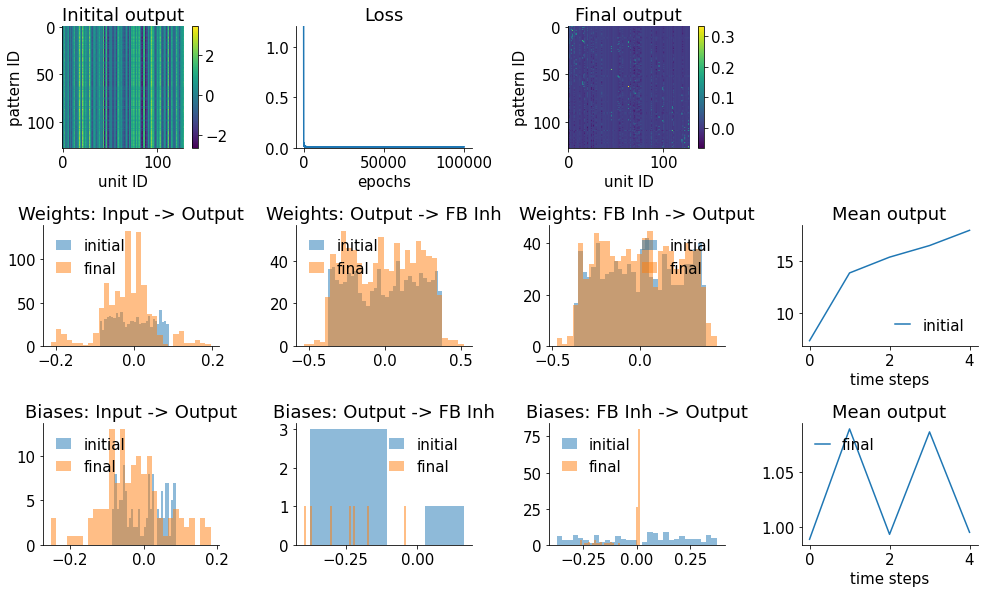

In [8]:
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,8.5))
axes = gs.GridSpec(nrows=3, ncols=12)
    
# Row 1: output activities
ax = fig.add_subplot(axes[0,0:3])
im = ax.imshow(output_init)
ax.set_title('Initital output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,3:6])
ax.plot(losses)
ax.set_xlabel('epochs')
ax.set_title('Loss')
ax.set_ylim([0,np.max(losses)])
# ax.set_ylim([0,1])

ax = fig.add_subplot(axes[0,6:9])
im = ax.imshow(output_final)
ax.set_title('Final output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[1,9:12])
ax.plot(mean_output_init,label='initial')
ax.set_title('Mean output')
ax.set_xlabel('time steps')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,9:12])
ax.plot(mean_output_final,label='final')
ax.set_title('Mean output')
ax.set_xlabel('time steps')
ax.legend(loc='best', frameon=False,handlelength=1)

# Row 2: weights
ax = fig.add_subplot(axes[1,0:3])
ax.hist(w_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,3:6])
ax.hist(w_init['fbi_out'],30,alpha=0.5,label='initial')
ax.hist(w_final['fbi_out'],30,alpha=0.5,label='final')
ax.set_title('Weights: Output -> FB Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,6:9])
ax.hist(w_init['out_fbi'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_fbi'],30,alpha=0.5,label='final')
ax.set_title('Weights: FB Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


# Row 3: biases
ax = fig.add_subplot(axes[2,0:3])
ax.hist(b_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Biases: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,3:6])
ax.hist(b_init['fbi_out'],4,alpha=0.5,label='initial')
ax.hist(b_final['fbi_out'],50,alpha=0.5,label='final')
ax.set_title('Biases: Output -> FB Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,6:9])
ax.hist(b_init['out_fbi'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_fbi'],30,alpha=0.5,label='final')
ax.set_title('Biases: FB Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


sns.despine()
fig.tight_layout()
plt.show()

# name = "backprop_network_FBI_MSE_ReLU"
# fig.savefig('../plots/'+name+'.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)